In [1]:
import os
os.getcwd() 
import pandas

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

In [3]:
import seaborn as sns
import copy
from pprint import pprint

In [4]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 999;

<IPython.core.display.Javascript object>

In [5]:

import copy
from pprint import pprint
def generate_step_slices(x):
    outcomes = x['Outcome']
    last_correct = 0
    for row in range(x.shape[0]):
        if((outcomes[row]) == "CORRECT"):
            yield x[last_correct:row+1]
            last_correct = row+1

            
def generate_step_dicts(student_table, KC='KC (Field)',only_first_error=True):
    opportunity_counts = {}
    for step_slice in generate_step_slices(student_table):
        step_name = step_slice[KC].iloc[-1]
        
        if(not isinstance(step_name,str) or step_name == ""):
            continue
        
        d = {}
        for _,table_row in step_slice.iterrows():
  
            if(str(table_row['Outcome']).strip().upper() == "INCORRECT"):
        
                d["general error"] = True
        
                if(table_row["error_type"] == "incorrect"):
                    d["incorrect"] = True

                elif(table_row['error_type'] == "misapplied"):
                    d["misapplied"] = True
                     
                elif(table_row['error_type'] == "out of graph"):  
                    d["out of graph"] = True
                    
                elif(table_row['error_type'] == "repeat"):  
                    d["repeat"] = True
                    
                elif(table_row['error_type'] == "when error"):  
                    d["when error"] = True    
                    
                elif(table_row['error_type'] == "where error"):  
                    d["where error"] = True 
                    
                elif(table_row['error_type'] == "wild error"):  
                    d["wild error"] = True 
            
                 
                    
            elif(str(table_row['Outcome']).strip().upper() == "HINT"):
                d["hint"] = True
                
            if(only_first_error):
                break
        d['KC'] = step_name 
        
        opportunity_counts[step_name] = opportunity_counts.get(step_name,0) + 1
        d['Opportunity'] = opportunity_counts[step_name]
        
        yield d

        
        
        
def increment_at_index(l,i,amount=0):
    if(i < len(l)):
        l[i] += amount
    elif(i == len(l)):
        l.extend([amount])
    else:
        raise ValueError("Nope", len(l), i)
        
                
def get_learning_curves(student_tables, KC='KC (Field)',only_first_error=True):
    d = {}

    kc_template = {"Counts": [], "Errors": [], "Incorrect": [], "Misapplied": [], "Out of graph" : [], "Repeat" :[], "When error":[], "Where error": [], "Wild error": [], "Hint error" : []}
    
    
    num = 0
    for st in student_tables:
        kc_dict = {}

        
        for sd in generate_step_dicts(st, KC=KC,only_first_error=only_first_error):
            kc_name = sd.get('KC',None)
            kc_data = kc_dict.get(kc_name, copy.deepcopy(kc_template))
            
            
            
            increment_at_index(kc_data["Counts"], sd["Opportunity"] -1, 1)
            
            inc, mis, out, rep, when, where, wild, h = sd.get('incorrect',False), sd.get('misapplied',False),sd.get('out of graph',False), sd.get('repeat',False), sd.get('when error',False), sd.get('where error',False), sd.get('wild error',False), sd.get('hint',False)  
            
            gen = sd.get('general error', False)
            
            
            op = sd["Opportunity"]
            indx = op-1
      
            increment_at_index(kc_data["Errors"], indx, 1 if inc or mis or out or rep or when or where or wild or h or gen else 0)
            
            increment_at_index(kc_data["Incorrect"], indx, 1 if inc else 0)
            
            increment_at_index(kc_data["Misapplied"], indx, 1 if mis else 0)
            
            increment_at_index(kc_data["Out of graph"], indx, 1 if out else 0)
            
            increment_at_index(kc_data["Repeat"], indx, 1 if rep else 0)
            
            increment_at_index(kc_data["When error"], indx, 1 if when else 0)
            
            increment_at_index(kc_data["Where error"], indx, 1 if where else 0)
            
            increment_at_index(kc_data["Wild error"], indx, 1 if wild else 0)
            
            increment_at_index(kc_data["Hint error"], indx, 1 if h else 0)
            
            kc_dict[kc_name] = kc_data
    
            
        d[num] = kc_dict
        num = num + 1
  
    return(d)




def gen_student_tables(df):
    student_tables = []
    for x in df['Anon Student Id'].unique():

        student_tables.append(df[df['Anon Student Id'] == x])
    return student_tables

def transaction_file_to_df(path):
    df = pandas.read_csv(path, lineterminator='\n', skip_blank_lines=True).replace({r'\r': ''}, regex=True)
    df = df.rename(index=str, columns={a:a.rstrip() for a in df.keys()})
    return df
            
def curves_from_transaction_file(df, KC='KC (Field)',only_first_error=True):

    df = transaction_file_to_df(df)          
    student_tables = gen_student_tables(df)
    learning_curves_by_kc = get_learning_curves(student_tables, KC=KC,only_first_error=only_first_error)
    return learning_curves_by_kc
    

                
 





In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

def graph_kc(name, kc):
    colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
    counts = np.array(kc['Counts'], dtype=np.float)
    error = np.array(kc['Errors'], dtype=np.float)/counts
    
    inc_error = np.array(kc['Incorrect Errors'], dtype=np.float)/counts
    mis_error = np.array(kc['Misapplied Errors'], dtype=np.float)/counts
    out_error = np.array(kc['Out of graph Errors'], dtype=np.float)/counts
    rep_error = np.array(kc['Repeat Errors'], dtype=np.float)/counts
    when_error = np.array(kc['When Errors'], dtype=np.float)/counts
    where_error = np.array(kc['Where Errors'], dtype=np.float)/counts  
    wild_error = np.array(kc['Wild Errors'], dtype=np.float)/counts
    hint_error = np.array(kc['Hint Errors'], dtype=np.float)/counts
    
    
    fig = plt.figure()
    
    plt.figure(figsize=(15,10))
    
    
    ax = plt.subplot(111)    
    x = np.arange(len(counts))
    
    ax.plot(x, error,  # marker="o",
            label='total error', color=colors['firebrick'])
    ax.plot(x, inc_error, # marker="d", 
            label='incorrect error', color=colors['gold'])
    ax.plot(x, mis_error, # marker="s",
            label='misapplied error', color=colors['green'])
    ax.plot(x, out_error, # marker="1" , 
            label='out of graph error', color=colors['dodgerblue'])
    ax.plot(x, rep_error, # marker = 'p',
            label='repeat error', color=colors['gray'])
    ax.plot(x, when_error, # marker = '*',
            label='when error', color=colors['magenta'])
    ax.plot(x, where_error, # marker = 'D',
            label='where error', color=colors['orange'])
    ax.plot(x, wild_error, # marker = 'x', 
            label='wild error', color=colors['lightblue'])
    
    ax.plot(x, hint_error, # marker = 'x', 
            label='hint error', color=colors['blueviolet'])
    
    
    ax.set_ylim([-0.01,1.025])

 #   ax.set_ylim([-0.01,0.2])
  

    
    ax.legend()
    plt.title('KC: %s' % name)
    plt.ylabel('Error')

    
    
#marker="+"
def add_counts(a,b):
    if len(a) < len(b):
        c = b.copy()
        c[:len(a)] += a
    else:
        c = a.copy()
        c[:len(b)] += b
    return c
def aggregate_curves(dictionary, selection=None):
    agg = {}
    for stu in dictionary.keys():
        d = dictionary[stu]
        if(selection == None): selection = d.keys();
        agg_curve = {}
        for (kc_name, kc) in d.items() :
        
            if(kc_name in selection):
   
                counts = np.array(kc['Counts'], dtype=np.float)
                errors = np.array(kc['Errors'], dtype=np.float)
                inc_errors = np.array(kc['Incorrect'], dtype=np.float)
                mis_errors = np.array(kc['Misapplied'], dtype=np.float)
                out_errors = np.array(kc['Out of graph'], dtype=np.float)
                rep_errors = np.array(kc['Repeat'], dtype=np.float)
                when_errors = np.array(kc['When error'], dtype=np.float)
                where_errors = np.array(kc['Where error'], dtype=np.float)
                wild_errors = np.array(kc['Wild error'], dtype=np.float)

                hint_errors = np.array(kc['Hint error'], dtype=np.float)

            
            
            
            
                agg_curve['Counts'] = add_counts(agg_curve.get('Counts',np.zeros(0)), counts)
                agg_curve['Errors'] = add_counts(agg_curve.get('Errors',np.zeros(0)), errors)
                agg_curve['Incorrect Errors'] = add_counts(agg_curve.get('Incorrect Errors',np.zeros(0)), inc_errors)
                agg_curve['Misapplied Errors'] = add_counts(agg_curve.get('Misapplied Errors',np.zeros(0)), mis_errors)
                agg_curve['Out of graph Errors'] = add_counts(agg_curve.get('Out of graph Errors',np.zeros(0)), out_errors)
                agg_curve['Repeat Errors'] = add_counts(agg_curve.get('Repeat Errors',np.zeros(0)), rep_errors)
                agg_curve['When Errors'] = add_counts(agg_curve.get('When Errors',np.zeros(0)), when_errors)
                agg_curve['Where Errors'] = add_counts(agg_curve.get('Where Errors',np.zeros(0)), where_errors)
                agg_curve['Wild Errors'] = add_counts(agg_curve.get('Wild Errors',np.zeros(0)), wild_errors)

                agg_curve['Hint Errors'] = add_counts(agg_curve.get('Hint Errors',np.zeros(0)), hint_errors)
            
        agg[stu] =  agg_curve 

            
    return agg



def find_longest(d):
    longest = 0
    for array in d.keys():
        if len(d[array]) > longest: longest = len(d[array]) 
    return longest


    

    
def get_boxplot(kc, error = 'Errors'):
    d = {}
    for stu in kc.keys():    
      #  print("stu", stu)
      #  print("stu's agg:", kc[stu])
        agg = kc[stu]
        if len(agg) != 0: 
            c = np.array(agg['Counts'], dtype=np.float)
            e = np.array(agg[error], dtype=np.float)
            d[stu] = e/c
    max_len = find_longest(d)
    l = []
    
    for stu in d.keys():
        temp = np.pad(d[stu], (0, max_len - len(d[stu])),  'constant', constant_values=(np.nan))
        l.append(temp)
        
    df = pandas.DataFrame(l,columns= np.arange(1, max_len+1))
    plt.figure(figsize=(15, 10))   
    df = (pandas.melt(df)).rename(index=str, columns={"variable": "opportunity", "value": "error rate"})
    
    
    return(df)


 

def compare_boxplots(df1, df2):
    df1['type'], df2['type'] = 'student', 'iso'
    df1 = df1.append(df2)
    return df1

    
    
    
            

In [7]:
path_student = "/Users/daniellaye/Desktop/human_sai/duplicate.csv"
human_curves_repeat = curves_from_transaction_file(path_student)



path_iso = "/Users/daniellaye/Desktop/iso_sai/match_sai_iso.csv"
iso_curves = curves_from_transaction_file(path_iso)




Text(0.5, 1.0, 'boxplot grouped by student and iso')

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

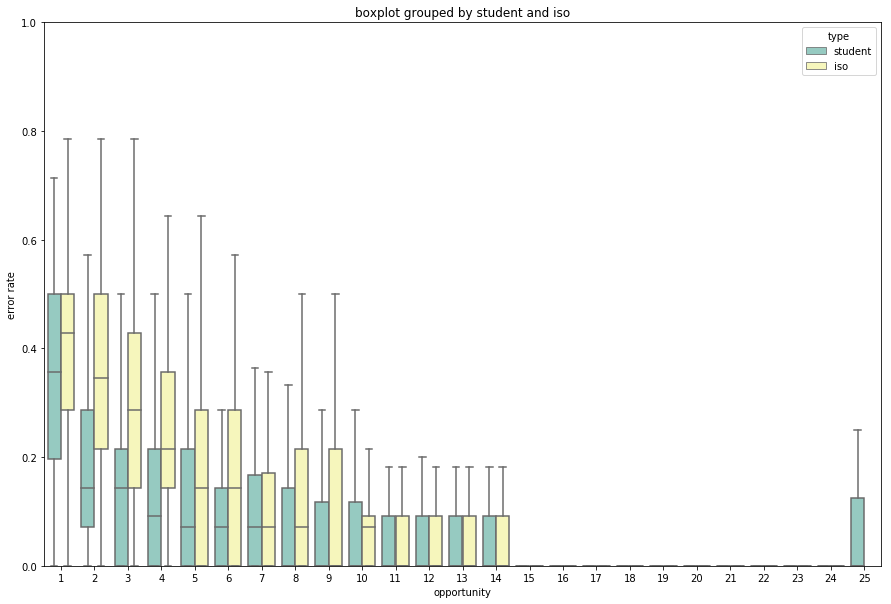

In [8]:
kc = aggregate_curves(human_curves_repeat)
s = get_boxplot(kc, error = 'Errors')
kc_iso = aggregate_curves(iso_curves)
i = get_boxplot(kc_iso, error = 'Errors')
res = compare_boxplots(s,i)
plt.figure(figsize=(15, 10))
plt.ylim(0, 1)
sns.boxplot(x="opportunity", y="error rate", hue="type", data=res, showfliers=False, palette="Set3").set_title('boxplot grouped by student and iso')



Text(0.5, 1.0, 'violinplot grouped by student and iso')

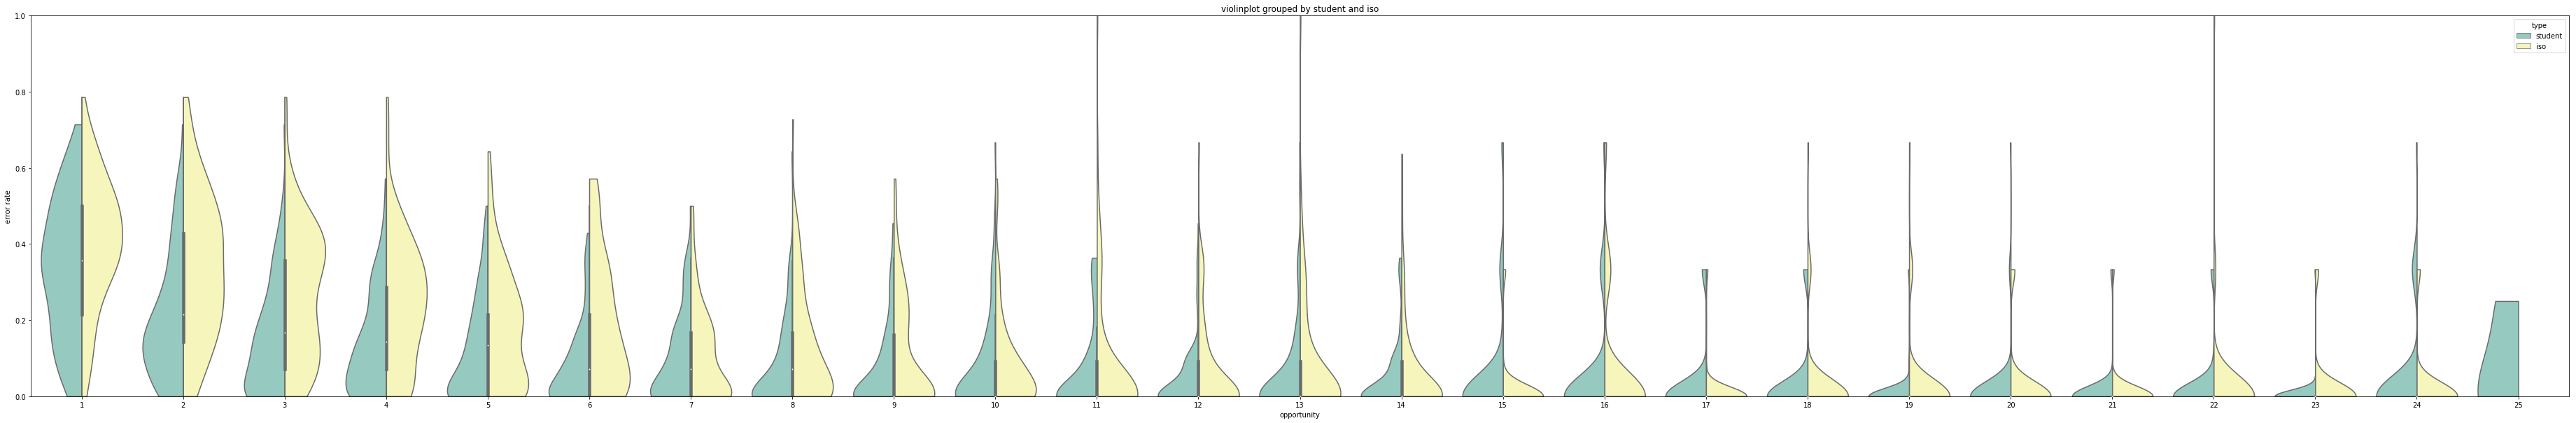

In [9]:
# Total errors split


plt.figure(figsize=(65, 10))
plt.ylim(0, 1)
sns.violinplot(x="opportunity", y="error rate", hue="type", data=res, cut = 0, split = True, scale ='count', palette="Set3").set_title('violinplot grouped by student and iso')



Text(0.5, 1.0, 'violinplot grouped by student and iso')

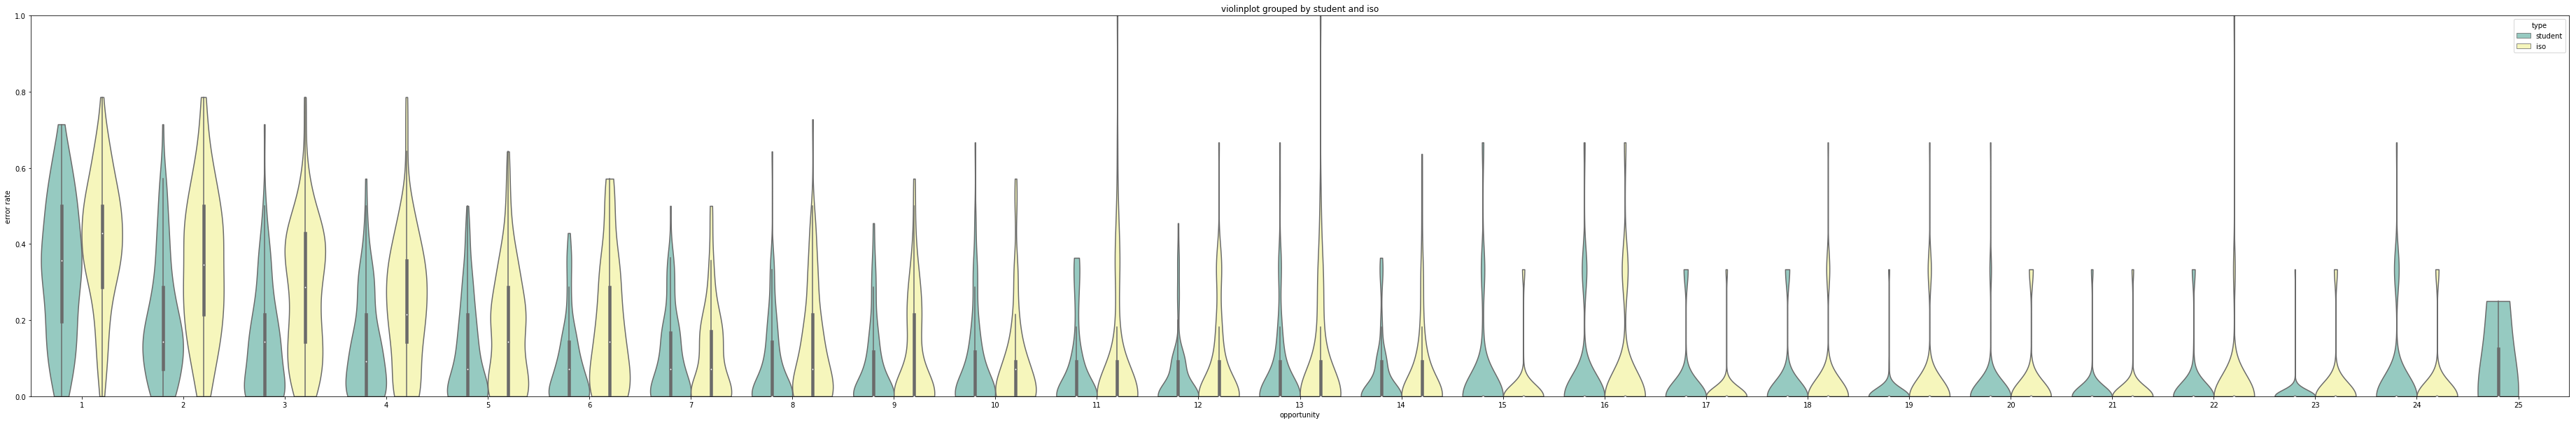

In [10]:
# Total errors 

plt.figure(figsize=(65, 10))
plt.ylim(0, 1)
sns.violinplot(x="opportunity", y="error rate", hue="type", data=res, cut = 0, scale ='count',palette="Set3").set_title('violinplot grouped by student and iso')


